In [1]:

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [4]:

vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [9]:
print(data[:10])
print(count[:10])
print(list(dictionary.items())[:10])
print(list(reverse_dictionary.items())[:10])

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
[['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
[('UNK', 0), ('the', 1), ('of', 2), ('and', 3), ('one', 4), ('in', 5), ('a', 6), ('to', 7), ('zero', 8), ('nine', 9)]
[(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine')]


In [10]:
data_index = 0

def generate_batch(batch_size, bag_window):
  global data_index
  span = 2 * bag_window + 1 # [ bag_window target bag_window ]
  batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)  
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    # just for testing
    buffer_list = list(buffer)
    labels[i, 0] = buffer_list.pop(bag_window)
    batch[i] = buffer_list
    # iterate to the next buffer
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
  data_index = 0
  batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
  print('\nwith bag_window = %d:' % (bag_window))  
  print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])  
  print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
    labels: ['originated', 'as', 'a', 'term']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
    labels: ['as', 'a', 'term', 'of']


Note the instruction change on the loss function, with reduce_sum to sum the word vectors in the context:

How to debug here:

"from IPython.core.debugger import set_trace"
"set_trace()"
"n - next()"
"c- continue()"
...

In [16]:
#from IPython.core.debugger import set_trace

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
###skip_window = 1 # How many words to consider left and right.
###num_skips = 2 # How many times to reuse an input to generate a label.
bag_window = 2 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  #set_trace()

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  # Since the default sequence of the "sampled_softmax_loss()" function parameters have been changed, the label of each parameters
  # are required. 
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embeds, 1),
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [19]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.903319
Nearest to th: sealing, wade, kala, rushton, sfsr, rubicon, overcrowded, argentinean,
Nearest to also: pohnpei, gordon, textile, durkheim, launcher, colic, adoptive, bayesian,
Nearest to some: precolonial, ay, bout, wavell, neuroimaging, marge, lagging, perfecting,
Nearest to can: ane, fairest, rb, unsuitable, minurso, specter, praying, hexafluoride,
Nearest to after: inflate, ploy, inwardly, revolutions, abrupt, nearest, gladys, wtc,
Nearest to than: viciously, interludes, academically, bribery, latinus, stateless, refraining, eisa,
Nearest to b: stirrups, ride, garlic, bedfordshire, eclectic, kzin, zhuhai, compromise,
Nearest to first: fulda, lifespans, weir, fung, bukovina, servicio, grattan, bolivia,
Nearest to this: katie, vanessa, baumgarten, nadezhda, solicitors, meteoric, microwave, chalker,
Nearest to he: tagus, qq, typology, ns, tfl, contesting, refreshed, nmos,
Nearest to his: woodcut, etymologically, heyday, lupin, johnstone, hor

Average loss at step 52000: 3.070735
Average loss at step 54000: 3.061983
Average loss at step 56000: 3.081624
Average loss at step 58000: 3.005589
Average loss at step 60000: 2.830717
Nearest to th: twentieth, nd, st, nineteenth, rd, third, seventeenth, antagonism,
Nearest to also: now, below, still, often, currently, disambiguation, generally, staub,
Nearest to some: many, several, numerous, various, all, these, most, certain,
Nearest to can: may, must, could, might, should, cannot, would, will,
Nearest to after: before, during, when, following, afterwards, verlag, since, upon,
Nearest to than: brahmins, darkly, garonne, lamenting, even, epsilon, brady, but,
Nearest to b: d, r, f, babbitt, x, computationally, p, c,
Nearest to first: last, second, same, next, third, best, final, fourth,
Nearest to this: which, it, another, what, that, rasterization, confessional, idriss,
Nearest to he: she, it, they, who, embroidery, eventually, pelts, fragmentary,
Nearest to his: her, their, its, my,

In [20]:

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

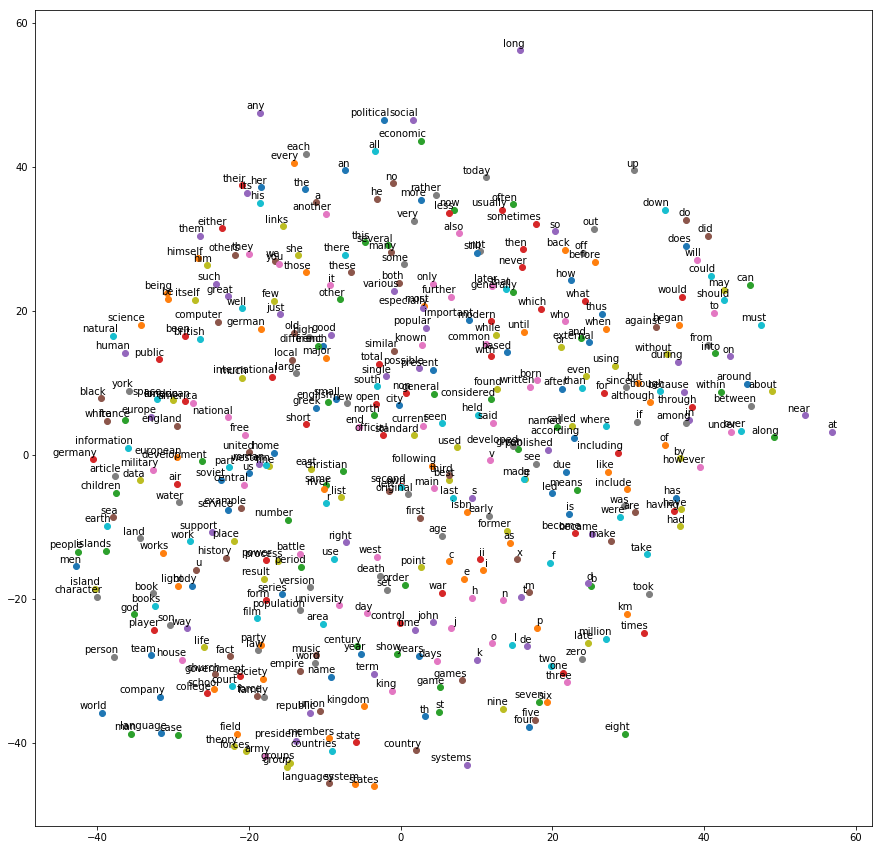

In [21]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)